# Primer análisis básico para definir posibles bases de datos a utilizar

### Cargo paquetes

In [1]:
# Load packages
import sys

import matplotlib

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
from numpy import ma 
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.colors as mcolors
import os
from matplotlib import gridspec
import seaborn as sns
import re

#import scipy.stats
#from scipy import signal
#import gc

#sys.path.insert(0, '/datos/julian.giles/Scripts/python')
#import juli_functions
#import plotly.offline as py
#import plotly.graph_objs as go
#import plotly.tools as tls
#from skimage.feature import peak_local_max
#import itertools
#import math
#import timeit
#from scipy import stats
#import collections


### Cargo datos

##### ERA5

In [2]:
# ERA5-Land data
era5land_path = '/datosfreyja/d1/GDATA/ERA5-Land/'
era5land = xr.open_mfdataset(era5land_path+'*/*.nc')

In [3]:
era5land

<xarray.Dataset>
Dimensions:    (latitude: 71, longitude: 51, time: 26304)
Coordinates:
  * longitude  (longitude) float32 -66.0 -65.9 -65.8 -65.7 ... -61.2 -61.1 -61.0
  * latitude   (latitude) float32 -29.0 -29.1 -29.2 -29.3 ... -35.8 -35.9 -36.0
  * time       (time) datetime64[ns] 2019-01-01 ... 2021-12-31T23:00:00
Data variables:
    lai_hv     (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    lai_lv     (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    swvl2      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    swvl3      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    swvl4      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-22 16:54:45 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

El problema con ERA5-Land es que las variables acumuladas están acumuladas desde la hora 0 de cada día. Es decir, la hora n es el acumulado entre 0 y n de ese día. Pasemos esas variables a acumulado por hora de la siguiente manera:
1. corremos el dataset 1 hora hacia atrás
2. en el dataset corrido, hacemos cero los valores a la hora 1 (que son los valores originalmente de la hora cero)
3. al dataset original le restamos este nuevo dataset corrido. Entonces, en cada hora se resta la hora anterior, excepto en la hora 1 donde no se resta nada (ya que el acumulado se resetea a las 00 h, no hay que restarle nada)

Además, hay que trasladar los datos a hora de las estaciones argentinas

Probemos primero con la variable tp:

In [4]:
era5land_adjusted = dict()
era5land_adjusted['tp'] = era5land['tp'] - era5land['tp'].shift({'time':1}, fill_value=0 )*(era5land['time']['time.hour']!=1)

Veamos que funcionó. Los valores a la hora 1 deben ser iguales en ambos datasets.

In [5]:
(era5land_adjusted['tp'][1] == era5land['tp'][1]).all().compute()

<xarray.DataArray ()>
array(True)
Coordinates:
    time     datetime64[ns] 2019-01-01T01:00:00

Correcto. Otra prueba: el valor a la hora 2 tiene que ser igual a la resta de las horas 2 y 1 del original:

In [6]:
(era5land_adjusted['tp'][2] == (era5land['tp'][2] - era5land['tp'][1])).all().compute()

<xarray.DataArray ()>
array(True)
Coordinates:
    time     datetime64[ns] 2019-01-01T02:00:00

Ahora sí, corremos el cálculo para todas las variables necesarias:

In [7]:
vars_to_adjust = ['tp', 'ro', 'sro']

era5land_adjusted = dict()
for var in list(era5land.data_vars):
    if var in vars_to_adjust:
        era5land_adjusted[var] = ( era5land[var] - era5land[var].shift({'time':1}, fill_value=0 )*(era5land['time']['time.hour']!=1) )/1000
        #se divide por mil al final de la cuenta porque estas variables de ERA5 están en 'm' y no en 'mm'
    else:
        era5land_adjusted[var] = era5land[var]

Pasamos el diccionario a un dataset:

In [8]:
era5land_adjusted_ds = xr.Dataset(era5land_adjusted)

Movemos el tiempo al huso horario de Argentina (UTC-3)

In [9]:
era5land_adjusted_ds['time'] = era5land_adjusted_ds['time'] - 3 * 3600000000000

In [10]:
era5land_adjusted_ds

<xarray.Dataset>
Dimensions:    (latitude: 71, longitude: 51, time: 26304)
Coordinates:
  * longitude  (longitude) float32 -66.0 -65.9 -65.8 -65.7 ... -61.2 -61.1 -61.0
  * latitude   (latitude) float32 -29.0 -29.1 -29.2 -29.3 ... -35.8 -35.9 -36.0
  * time       (time) datetime64[ns] 2018-12-31T21:00:00 ... 2021-12-31T20:00:00
Data variables:
    lai_hv     (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    lai_lv     (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    swvl2      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    swvl3      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    swvl4      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 71, 51), meta=np.ndarray>

##### Estaciones

In [11]:
# Cargo Lista de ubicaciones
obs_path = '/datos/julian.giles/flash_flood/datos_estaciones/'
ubicaciones = pd.read_csv(obs_path+'ubicaciones_estaciones.csv', sep=';')
ubicaciones

,nombre,lat,lon,grupo
0,Dique Aforador,-32.931762,-62.332002,1
1,Justiniano Posse,-32.895530,-62.648230,1
2,Monte Buey,-32.897552,-62.442105,1
3,Buchardo,-34.706000,-63.503000,2
4,Rio Cuarto,-33.161200,-64.357000,3
5,Alpa Corral,-32.689484,-64.720150,3
6,Ruta8,-33.138248,-64.284920,3
7,RP26,-34.762833,-63.644930,2
8,FAV - UNRC,-32.968273,-64.652778,3
9,Tincunaco,-32.903340,-64.716535,3


In [12]:
datos = dict()
files_list = os.listdir(obs_path)
for nombre in ubicaciones['nombre']:
    for file in files_list:
        if re.search("".join(nombre.split(' ')), file, flags=re.IGNORECASE):
            datos[nombre] = pd.read_csv(obs_path+file, sep=';',low_memory=False, skip_blank_lines=True).dropna(how='all')
            
            if 'Fecha' in datos[nombre].columns:
                datos[nombre] = pd.read_csv(obs_path+file, sep=';', skip_blank_lines=True, parse_dates=['Fecha'], dayfirst=True).dropna(how='all')
                
            elif 'Fecha y Hora' in datos[nombre].columns:
                datos[nombre] = pd.read_csv(obs_path+file, sep=';', skip_blank_lines=True, parse_dates=['Fecha y Hora'], dayfirst=True).dropna(how='all')
                
            else:
                datos[nombre] = pd.read_csv(obs_path+file, sep=';', skip_blank_lines=True, header=1).dropna(how='all')
                
                if 'Fecha' in datos[nombre].columns:
                    datos[nombre] = pd.read_csv(obs_path+file, sep=';', skip_blank_lines=True, header=1, parse_dates=['Fecha'], dayfirst=True).dropna(how='all')

                elif 'Fecha y Hora' in datos[nombre].columns:
                    datos[nombre] = pd.read_csv(obs_path+file, sep=';', skip_blank_lines=True, header=1, parse_dates=['Fecha y Hora'], dayfirst=True).dropna(how='all')


/home/julian.giles/anaconda3/envs/work5/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/julian.giles/anaconda3/envs/work5/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/julian.giles/anaconda3/envs/work5/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/julian.giles/anaconda3/envs/work5/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or 

In [27]:
datos['FAV - UNRC']

,Fecha,Temperatura [�C],Humedad [%HR],Punto de roc�o [�C],Registro de Lluvia [mm],Velocidad de Viento [Km/h],Direccion de Viento [�],Direcci�n de Viento-(Rosa de los Vientos) [],Rafaga de Viento [km/h],Presion [hPa],Radiacion Solar [w/m2],Temperatura de suelo [�C],Indice de peligro de incendios [-]
0,2019-01-01 00:00:00,22.9,79.4,NaN,0.0,16.3,180.0,S,27.9,936.9,NaN,NaN,NaN
1,2019-01-01 00:10:00,22.9,79.2,NaN,0.0,17.9,180.0,S,31.3,936.9,NaN,NaN,NaN
2,2019-01-01 00:20:00,22.9,78.7,NaN,0.0,17.0,180.0,S,29.1,936.2,NaN,NaN,NaN
3,2019-01-01 00:30:00,22.9,79.0,NaN,0.0,17.2,180.0,S,28.3,936.2,NaN,NaN,NaN
4,2019-01-01 00:40:00,22.9,78.9,NaN,0.0,16.0,180.0,S,25.5,936.9,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163739,2022-03-10 16:20:00,23.7,39.0,9.0,0.0,3.6,90.0,E,9.1,941.2,531.9,20.2,NaN
163740,2022-03-10 16:30:00,23.7,39.5,9.1,0.0,6.5,157.5,SSE,12.8,942.5,501.5,20.3,NaN
163741,2022-03-10 16:40:00,23.6,40.5,9.4,0.0,5.9,225.0,SO,14.5,941.9,480.9,20.3,NaN
163742,2022-03-10 16:50:00,23.6,41.1,9.6,0.0,5.5,112.5,ESE,8.5,941.9,443.5,20.4,NaN


#### Mapa con las ubicaciones de los datos de estaciones

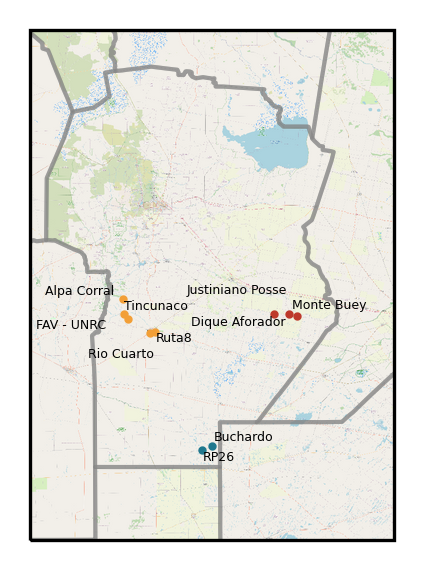

In [14]:
# Plot de las ubicaciones en un mapa, coloreadas según grupo

markercols = ['#bd392a', '#20788e', '#f29f37', '#007c38']

from adjustText import adjust_text

fig1 = plt.figure( figsize=(4,2),dpi=300)
ax = fig1.add_axes([0.05,0.05,0.95,0.85], projection= ccrs.PlateCarree(central_longitude=0.0) )

texts = []
for nloc in range(len(ubicaciones)):
    plt.plot(ubicaciones.iloc[nloc]['lon'], ubicaciones.iloc[nloc]['lat'],
             color=markercols[int(ubicaciones.iloc[nloc]['grupo'])-1], linewidth=2, marker='o', markersize=1,
             transform=ccrs.Geodetic())

    texts.append(plt.text(ubicaciones.iloc[nloc]['lon'], ubicaciones.iloc[nloc]['lat'], ubicaciones.iloc[nloc]['nombre'],
             horizontalalignment='right',
             transform=ccrs.Geodetic(), fontsize=3) )


ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=1, alpha=0.7) #countries
#ax.stock_img()
ax.set_extent([-66, -61, -36,  -29])

import cartopy.io.img_tiles as cimgt

request = cimgt.OSM() # .GoogleTiles() es otra opcion
ax.add_image(request, 10, interpolation='spline36')

import cartopy.io.shapereader as shpreader
fname = '/datos/julian.giles/shapefiles/Argentina/gadm40_ARG_1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(),
                  edgecolor='gray', facecolor='None',  alpha=0.5)

adjust_text(texts) #tiene que ir al final, sino no sale el background

plt.show()

#### Buscamos desde qué período analizar según la calidad de los datos

Grupo 1:

<AxesSubplot:xlabel='Fecha y Hora'>

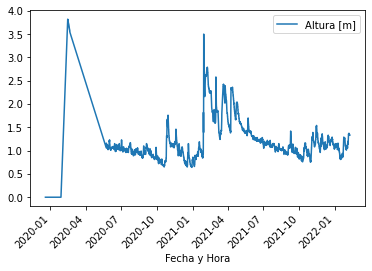

In [14]:
datos['Dique Aforador'].plot(x='Fecha y Hora', rot=45)


<AxesSubplot:xlabel='Fecha'>

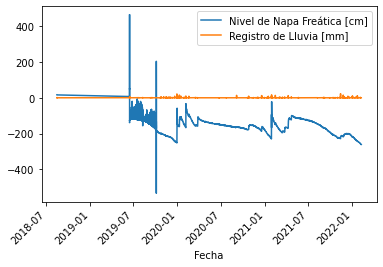

In [15]:
datos['Justiniano Posse'].plot(x='Fecha',  y=['Nivel de Napa Freática [cm]', 'Registro de Lluvia [mm]'], rot=45)


<AxesSubplot:xlabel='Fecha'>

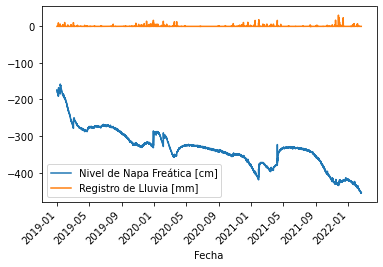

In [16]:
datos['Monte Buey'].plot(x='Fecha',  y=['Nivel de Napa Freática [cm]', 'Registro de Lluvia [mm]'], rot=45)


Aprox desde Junio 2020. Creamos un nuevo dataframe para ir guardando los datos recortados. Pasamos los datos a horarios.

In [120]:
fromdate = '2020-06-01 00:00:00'
todate = '2021-12-31 00:00:00'

datos_2 = dict()

# IMPORTANTE: agregamos resample horario (a pesar de que ya está horario) para rellenar datos faltantes
datos_2['Dique Aforador'] = datos['Dique Aforador'].loc[(datos['Dique Aforador']['Fecha y Hora']>=fromdate) & (datos['Dique Aforador']['Fecha y Hora']<=todate)].set_index('Fecha y Hora').resample('H').mean().interpolate()

# IMPORTANTE!!!! como los datos son acumulados/promediados en el periodo anterior (los 10 min anteriores), hay que darle las opciones label='right', closed='right' para que los datos pasen a representar lo acumulado/promediado en la hora anterior
datos_2['Justiniano Posse'] = datos['Justiniano Posse'].loc[(datos['Justiniano Posse']['Fecha']>=fromdate) & (datos['Justiniano Posse']['Fecha']<=todate)].set_index('Fecha').resample('H', label='right', closed='right').mean().interpolate()
datos_2['Justiniano Posse']['Registro de Lluvia [mm]'] = datos_2['Justiniano Posse']['Registro de Lluvia [mm]']*6


datos_2['Monte Buey'] = datos['Monte Buey'].loc[(datos['Monte Buey']['Fecha']>=fromdate) & (datos['Monte Buey']['Fecha']<=todate)].set_index('Fecha').resample('H', label='right', closed='right').mean().interpolate()
datos_2['Monte Buey']['Registro de Lluvia [mm]'] = datos_2['Monte Buey']['Registro de Lluvia [mm]']*6


Grupo 2:

<AxesSubplot:xlabel='Fecha y Hora'>

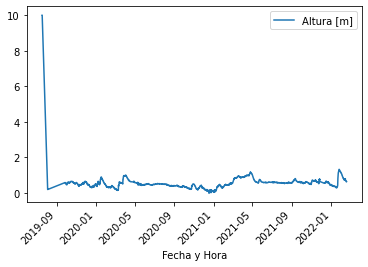

In [18]:
datos['RP26'].plot(x='Fecha y Hora', rot=45)


<AxesSubplot:xlabel='Fecha'>

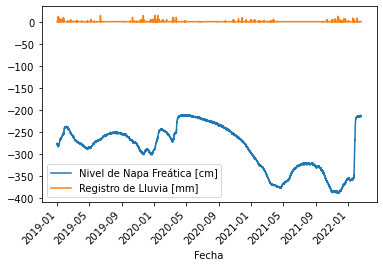

In [19]:
datos['Buchardo'].plot(x='Fecha',  y=['Nivel de Napa Freática [cm]', 'Registro de Lluvia [mm]'], rot=45)


Aprox desde Septiembre 2019. Pasamos los datos a horarios y los agregamos al nuevo dataframe

In [122]:
fromdate = '2019-09-01 00:00:00'
todate = '2021-12-31 00:00:00'

datos_2['RP26'] = datos['RP26'].loc[(datos['RP26']['Fecha y Hora']>=fromdate) & (datos['RP26']['Fecha y Hora']<=todate)].set_index('Fecha y Hora').resample('H').mean().interpolate()

datos_2['Buchardo'] = datos['Buchardo'].loc[(datos['Buchardo']['Fecha']>=fromdate) & (datos['Buchardo']['Fecha']<=todate)].set_index('Fecha').resample('H', label='right', closed='right').mean().interpolate()
datos_2['Buchardo']['Registro de Lluvia [mm]'] = datos_2['Buchardo']['Registro de Lluvia [mm]']*6

Grupo 3:

<AxesSubplot:xlabel='Fecha y Hora'>

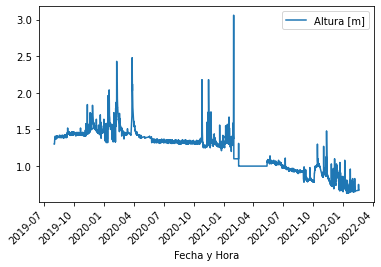

In [25]:
datos['Ruta8'].plot(x='Fecha y Hora', rot=45)


<AxesSubplot:xlabel='Fecha'>

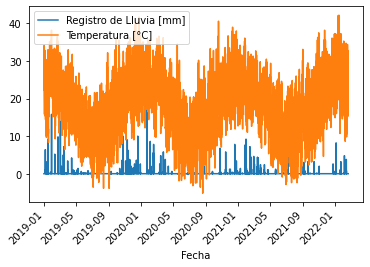

In [22]:
datos['Rio Cuarto'].plot(x='Fecha',  y=['Registro de Lluvia [mm]', 'Temperatura [°C]'], rot=45)


<AxesSubplot:xlabel='Fecha'>

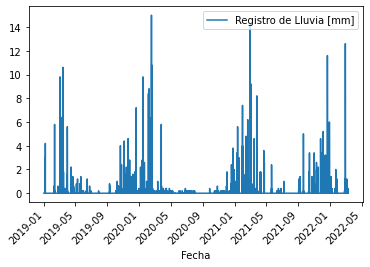

In [20]:
datos['FAV - UNRC'].plot(x='Fecha',  y=['Registro de Lluvia [mm]'], rot=45)

<AxesSubplot:xlabel='Fecha y Hora', ylabel='Altura [m]'>

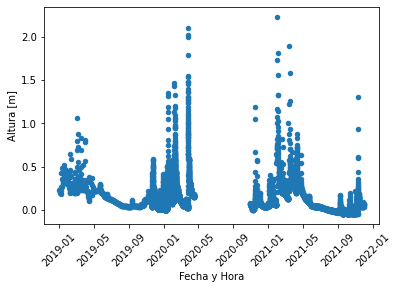

In [23]:
datos['Tincunaco'].plot.scatter(x='Fecha y Hora', y='Altura [m]', rot=45)

Aprox desde Agosto 2019. Pasamos los datos a horarios y los agregamos al nuevo dataframe

In [123]:
fromdate = '2019-08-01 00:00:00'
todate = '2021-12-31 00:00:00'

datos_2['Ruta8'] = datos['Ruta8'].loc[(datos['Ruta8']['Fecha y Hora']>=fromdate) & (datos['Ruta8']['Fecha y Hora']<=todate)].set_index('Fecha y Hora').resample('H').mean().interpolate()

datos_2['Rio Cuarto'] = datos['Rio Cuarto'].loc[(datos['Rio Cuarto']['Fecha']>=fromdate) & (datos['Rio Cuarto']['Fecha']<=todate)].set_index('Fecha').resample('H', label='right', closed='right').mean().interpolate()
datos_2['Rio Cuarto']['Registro de Lluvia [mm]'] = datos_2['Rio Cuarto']['Registro de Lluvia [mm]']*6

Grupo 4:

<AxesSubplot:xlabel='Fecha y Hora'>

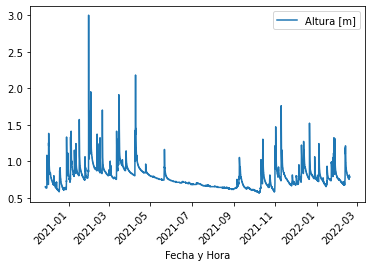

In [24]:
datos['Alpa Corral'].plot(x='Fecha y Hora', rot=45)

Tomamos toda la serie. Agregamos al nuevo dataframe

In [124]:
datos_2['Alpa Corral'] = datos['Alpa Corral'].set_index('Fecha y Hora').resample('H').mean().interpolate()

#### Comparemos algunos datos con ERA5

Justiniano Posse

In [125]:
lon_jp = float(ubicaciones[ubicaciones['nombre']=='Justiniano Posse']['lon'])
lat_jp = float(ubicaciones[ubicaciones['nombre']=='Justiniano Posse']['lat'])
fechas = slice(str(datos_2['Justiniano Posse'].index[0]), str(datos_2['Justiniano Posse'].index[-1]))

era5land_jp = era5land_adjusted_ds.loc[{'time': fechas, 'longitude':slice(lon_jp-0.1/2, lon_jp+0.1/2), 'latitude':slice(lat_jp+0.1/2, lat_jp-0.1/2)}].to_dataframe().reset_index()
era5land_jp['time'] = pd.to_datetime(era5land_jp['time'], infer_datetime_format=True)

<IPython.core.display.Javascript object>


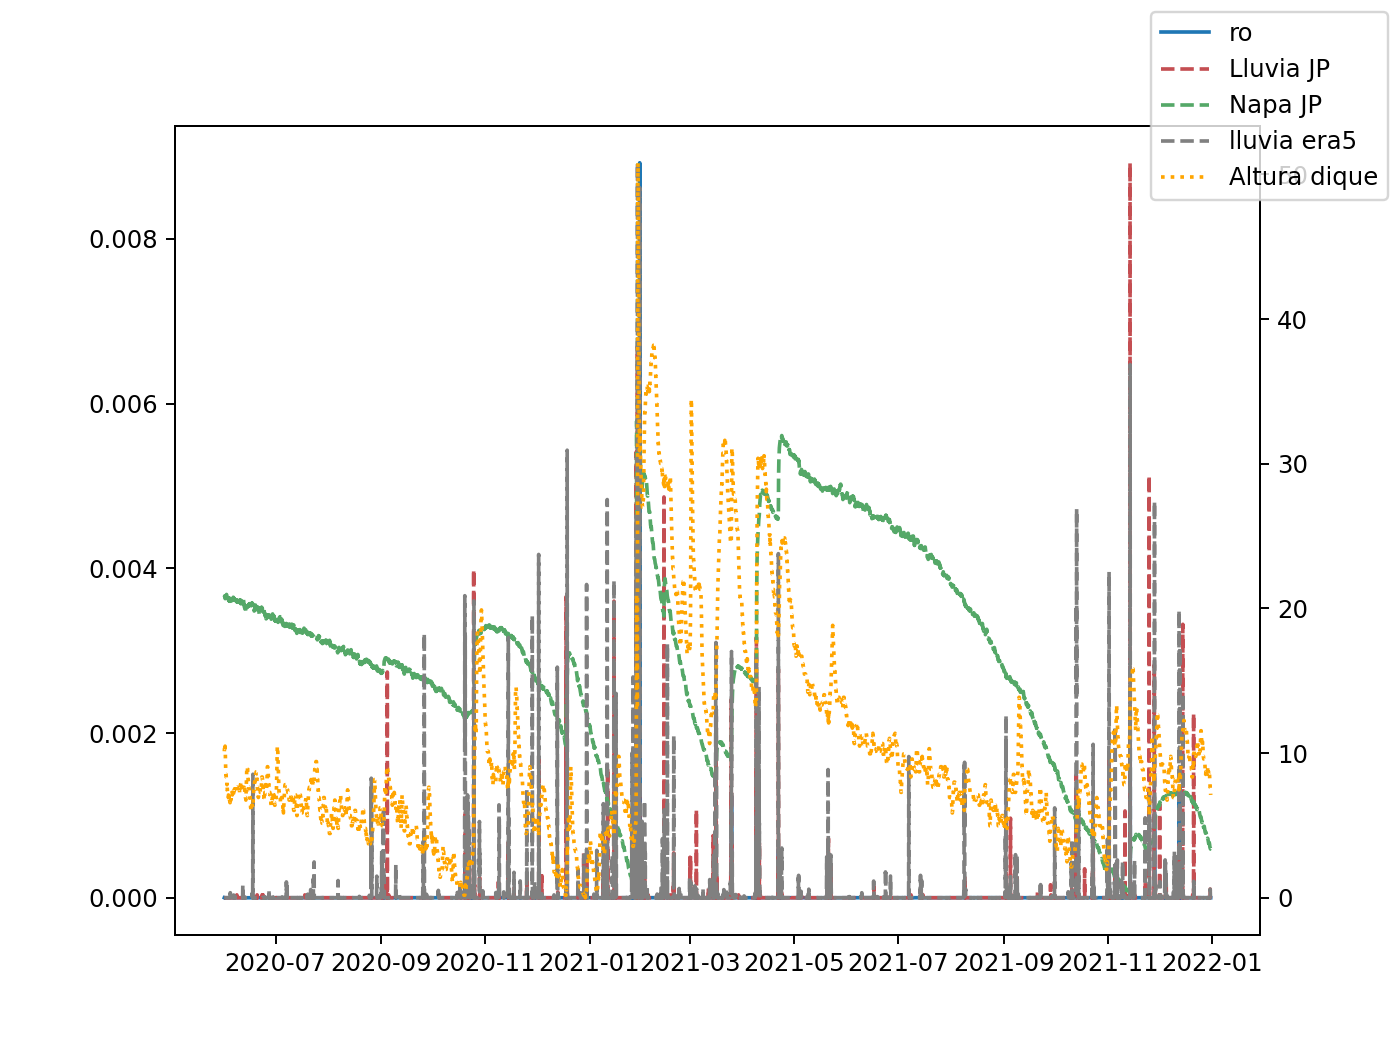

In [152]:
#Plot
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(era5land_jp['time'], era5land_jp['ro'], label='ro')
ax2 = ax.twinx()
ax2.plot(datos_2['Justiniano Posse'].index, datos_2['Justiniano Posse']['Registro de Lluvia [mm]'], label='Lluvia JP',  color="r", ls = 'dashed')
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
ax3.plot(datos_2['Justiniano Posse'].index, datos_2['Justiniano Posse']['Nivel de Napa Freática [cm]'], label='Napa JP',  color="g", ls = 'dashed')
ax4 = ax.twinx()
ax4.spines["right"].set_position(("axes", 1.4))
ax4.plot(era5land_jp['time'], era5land_jp['tp'], label='lluvia era5',  color="grey", ls = 'dashed')
ax5 = ax.twinx()
ax5.spines["right"].set_position(("axes", 1.6))
ax5.plot(datos_2['Dique Aforador'].index, datos_2['Dique Aforador']['Altura [m]'], label='Altura dique',  color="orange", ls = 'dotted')


ax.figure.legend()
plt.show()


Hacemos matriz de correlación entre algunas variables para confirmar que los datos son aceptablemente coherentes

In [127]:
list_df = [era5land_jp['ro'].reset_index(drop=True), era5land_jp['tp'].reset_index(drop=True),
               datos_2['Justiniano Posse']['Registro de Lluvia [mm]'].reset_index(drop=True),
               datos_2['Justiniano Posse']['Nivel de Napa Freática [cm]'].reset_index(drop=True),
               datos_2['Dique Aforador']['Altura [m]'].reset_index(drop=True)]

In [128]:
headers = ['era5 RO', 'era5 PP', 'jp PP', 'jp NF', 'dique aforador ALTURA' ]
df_pre_corr = pd.concat(list_df, axis=1, keys=headers)

corr = df_pre_corr.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,era5 RO,era5 PP,jp PP,jp NF,dique aforador ALTURA
era5 RO,1.000000,0.614424,0.144026,0.035584,0.068247
era5 PP,0.614424,1.000000,0.362806,-0.029642,0.053259
jp PP,0.144026,0.362806,1.000000,-0.042439,0.017496
jp NF,0.035584,-0.029642,-0.042439,1.000000,0.379343
dique aforador ALTURA,0.068247,0.053259,0.017496,0.379343,1.000000


La matriz de correlación da horrible. Es difícil comparar series temporales de PP que son muy ruidosas. Probemos haciendo un acumulado móvil.

In [147]:
df_pre_corr_2 = pd.concat([df_pre_corr[['era5 RO', 'era5 PP', 'jp PP']].rolling(12).sum(),
                          df_pre_corr[['jp NF', 'dique aforador ALTURA']]], axis=1)

In [148]:
corr2 = df_pre_corr_2.corr()
corr2.style.background_gradient(cmap='coolwarm', axis=None)

,era5 RO,era5 PP,jp PP,jp NF,dique aforador ALTURA
era5 RO,1.000000,0.694955,0.362931,0.083718,0.150887
era5 PP,0.694955,1.000000,0.644135,-0.008489,0.124942
jp PP,0.362931,0.644135,1.000000,-0.019197,0.106626
jp NF,0.083718,-0.008489,-0.019197,1.000000,0.379343
dique aforador ALTURA,0.150887,0.124942,0.106626,0.379343,1.000000


Tomando ventanas móviles de varias horas e incluso varios días, mejora la correlación entre ERA5 y los datos de estación. 

Hagamos unos scatterplots para ver de otra forma si las variables se comportan parecido:

<IPython.core.display.Javascript object>


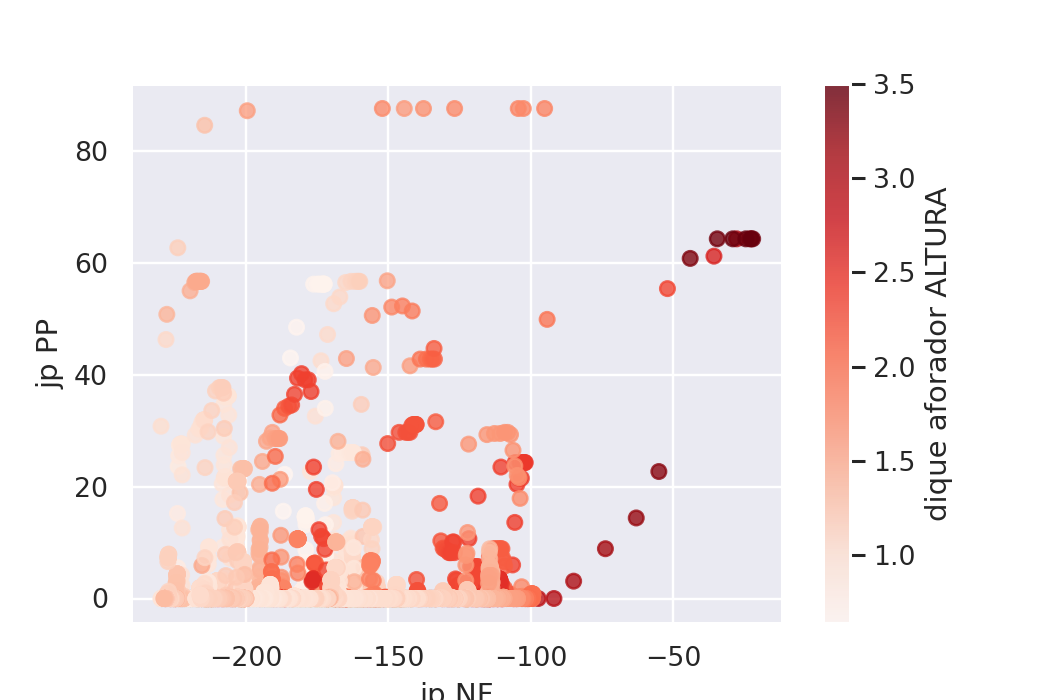

In [166]:
x_data = 'jp NF'
y_data = 'jp PP'
c_data = 'dique aforador ALTURA'

fig, ax = plt.subplots(figsize=(6,4))
sns.set_theme()
plt.scatter(df_pre_corr_2[x_data], df_pre_corr_2[y_data], alpha = .8, 
            c = df_pre_corr_2[c_data], cmap = 'Reds')
plt.xlabel(x_data); plt.ylabel(y_data)
cbar = plt.colorbar(label=c_data)

<IPython.core.display.Javascript object>


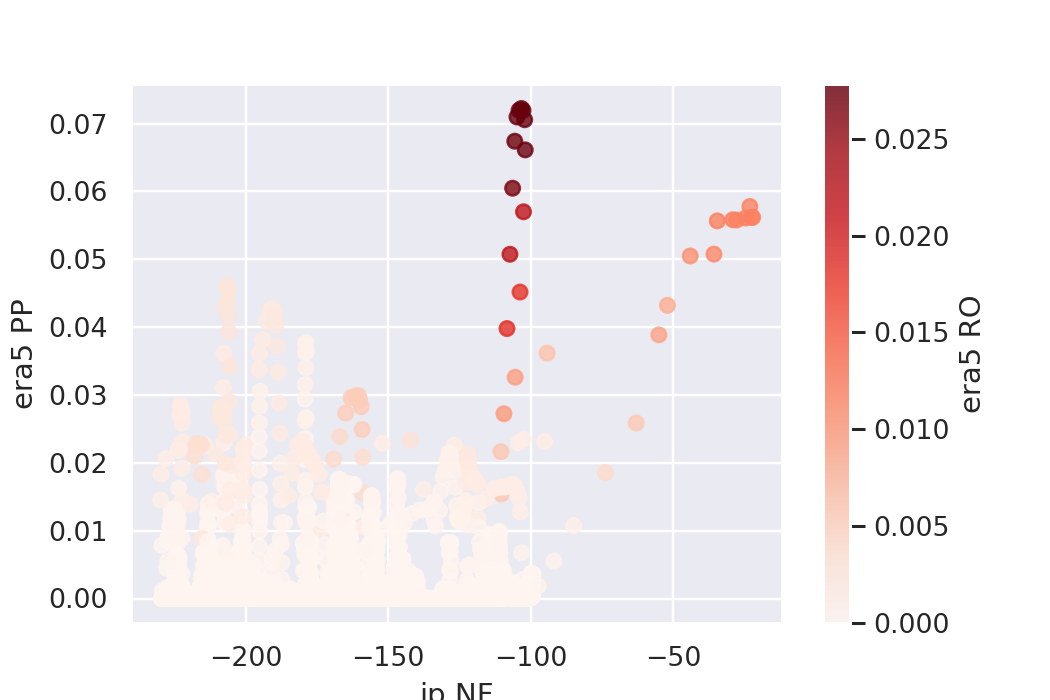

In [167]:
x_data = 'jp NF'
y_data = 'era5 PP'
c_data = 'era5 RO'

fig, ax = plt.subplots(figsize=(6,4))
sns.set_theme()
plt.scatter(df_pre_corr_2[x_data], df_pre_corr_2[y_data], alpha = .8, 
            c = df_pre_corr_2[c_data], cmap = 'Reds')
plt.xlabel(x_data); plt.ylabel(y_data)
cbar = plt.colorbar(label=c_data)

<IPython.core.display.Javascript object>


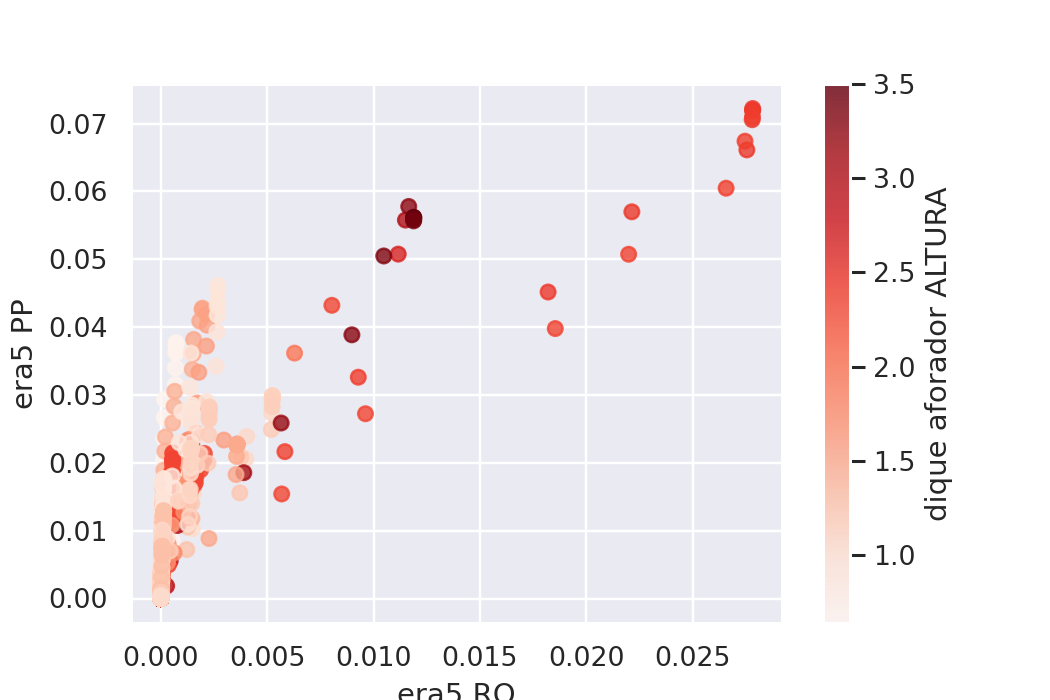

In [168]:
x_data = 'era5 RO'
y_data = 'era5 PP'
c_data = 'dique aforador ALTURA'

fig, ax = plt.subplots(figsize=(6,4))
sns.set_theme()
plt.scatter(df_pre_corr_2[x_data], df_pre_corr_2[y_data], alpha = .8, 
            c = df_pre_corr_2[c_data], cmap = 'Reds')
plt.xlabel(x_data); plt.ylabel(y_data)
cbar = plt.colorbar(label=c_data)

A pesar de las obvias diferencias, hay coherencia respecto a que mayores valores de napa y de lluvia/runoff van de la mano de mayores valores de altura del río.

Con esto concluimos la exploración preliminar de datos. La idea sería usar las alturas de los ríos y/o runoff como targets, ya sea para regresión o para clasificación de eventos de inundación rápida. Tener en cuenta que deberíamos usar métodos de preprocesamiento (antes del modelo de ML) que hagan variantes de las features tomando series acumuladas y lagueadas.

Podríamos considerar como features variables atmosféricas de ERA5 o estaciones y como targets la altura de los ríos o runoff de ERA5; distintas combinaciones de ambas fuentes de datos.

##  de aca para abajo son cosas viejas

In [4]:
# Observations
obs_path = '/datos/julian.giles/flash_flood/justiniano_posse/'

justiniano_posse = pd.read_csv(obs_path+'ClimaReporte_omixom_JustinianoPosse.csv', sep=';', low_memory=False, skip_blank_lines=True, parse_dates=['Fecha'], infer_datetime_format=True).dropna(how='all')

dique_aforador = pd.read_csv(obs_path+'Altura_diqueAforador_Estacion-4216.csv', sep=';', low_memory=False, skip_blank_lines=True, header=1, parse_dates=['Fecha y Hora'], infer_datetime_format=True).dropna(how='all')

landsat = pd.read_csv(obs_path+'data_Cappellettietal.csv', sep=',', low_memory=False, skip_blank_lines=True, parse_dates=['Fecha'], infer_datetime_format=True).dropna(how='all')

In [5]:
justiniano_posse

,Fecha,Temperatura [°C],Humedad [%HR],Punto de rocío [°C],Registro de Lluvia [mm],Velocidad de Viento [Km/h],Direccion de Viento [°],Dirección de Viento-(Rosa de los Vientos) [],Rafaga de Viento [km/h],Presion [hPa],Radiacion Solar [w/m2],Temperatura de suelo [°C],Nivel de Napa Freática [cm]
0,2018-08-14 11:20:00,18.1,32.0,NaN,0.0,5.9,67.5,ENE,7.7,978.8,13.0,17.2,17.0
1,2018-08-14 11:30:00,18.1,31.7,NaN,0.0,6.0,67.5,ENE,7.4,978.8,13.0,17.2,17.0
2,2018-08-14 11:40:00,18.1,31.8,NaN,0.0,6.0,67.5,ENE,7.9,977.5,13.0,17.2,17.0
3,2018-08-14 11:50:00,18.1,32.0,NaN,0.0,6.1,67.5,ENE,8.4,977.5,13.0,17.2,17.0
4,2018-08-14 12:00:00,18.1,32.0,NaN,0.0,6.1,67.5,ENE,8.1,977.5,12.0,17.3,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139458,2022-02-08 10:30:00,23.1,64.8,16.1,0.0,9.8,67.5,ENE,20.3,1003.8,677.4,19.6,-261.2
139459,2022-02-08 10:40:00,23.3,64.4,16.2,0.0,10.5,67.5,ENE,20.7,1003.8,705.1,19.7,-261.2
139460,2022-02-08 10:50:00,23.6,65.5,16.8,0.0,9.5,112.5,ESE,21.3,1002.5,728.8,19.7,-261.2
139461,2022-02-08 11:00:00,23.9,64.5,16.8,0.0,10.5,112.5,ESE,23.0,1001.9,752.5,19.8,-261.2


<AxesSubplot:xlabel='Fecha'>

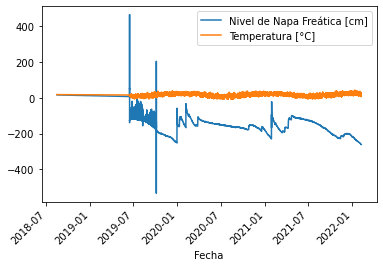

In [6]:
justiniano_posse.plot(x='Fecha', y=['Nivel de Napa Freática [cm]', 'Temperatura [°C]'], rot=45)

In [7]:
dique_aforador

,Fecha y Hora,Altura [m]
0,2019-12-19 13:00:00,0.00
1,2019-12-19 14:00:00,0.00
2,2019-12-19 15:00:00,0.00
3,2019-12-19 16:00:00,0.00
4,2019-12-19 17:00:00,0.00
...,...,...
14778,2022-02-08 15:00:00,1.34
14779,2022-02-08 16:00:00,1.34
14780,2022-02-08 17:00:00,1.33
14781,2022-02-08 18:00:00,1.33


<AxesSubplot:xlabel='Fecha y Hora'>

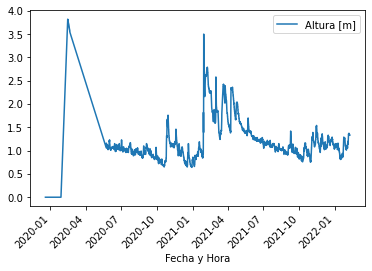

In [8]:
dique_aforador.plot(x='Fecha y Hora', rot=45)


In [9]:
landsat

,Fecha,Lluvia Acumulada [mm],Rolling_5_Sum,nivel napa promedio [cm],flood_surface,mixwater_surface
0,2019-09-01,0.0,0.0,-139.9,5400.0,5172.0
1,2019-09-02,0.0,0.0,-141.3,NaN,NaN
2,2019-09-03,0.0,0.0,-144.5,NaN,NaN
3,2019-09-04,0.0,0.0,-145.5,NaN,NaN
4,2019-09-05,0.0,0.0,-144.3,NaN,NaN
...,...,...,...,...,...,...
605,2021-04-28,0.2,0.2,-104.0,NaN,NaN
606,2021-04-29,0.0,0.2,-104.7,NaN,NaN
607,2021-04-30,0.0,0.2,-104.8,NaN,NaN
608,2021-05-01,0.0,0.2,-105.3,4071.0,3616.0


<AxesSubplot:xlabel='Fecha'>

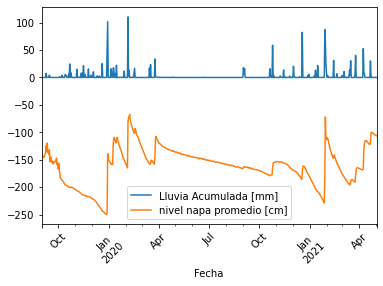

In [10]:
landsat.plot(x='Fecha', y=['Lluvia Acumulada [mm]', 'nivel napa promedio [cm]'], rot=45)


#### Busco arrancar desde donde los datos parecen más decentes, veamos junio 2020

<AxesSubplot:xlabel='Fecha'>

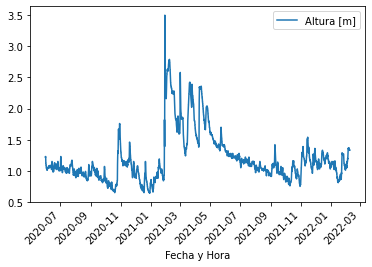

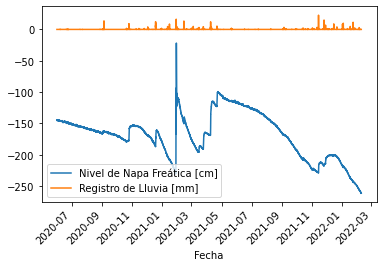

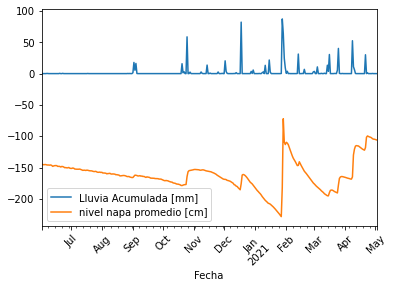

In [11]:
fromdate = '2020-06-01 00:00:00'
#todate = '2021-12-31 00:00:00'

dique_aforador_short = dique_aforador.loc[dique_aforador['Fecha y Hora']>fromdate].reset_index(drop=True)
justiniano_posse_short = justiniano_posse.loc[justiniano_posse['Fecha']>fromdate].reset_index(drop=True)
landsat_short = landsat.loc[landsat['Fecha']>fromdate].reset_index(drop=True)

dique_aforador_short.plot(x='Fecha y Hora', y='Altura [m]', rot=45)
justiniano_posse_short.plot(x='Fecha', y=['Nivel de Napa Freática [cm]', 'Registro de Lluvia [mm]'], rot=45)
landsat_short.plot(x='Fecha', y=['Lluvia Acumulada [mm]', 'nivel napa promedio [cm]'], rot=45)


#### Comparemos algunas variables entre datasets

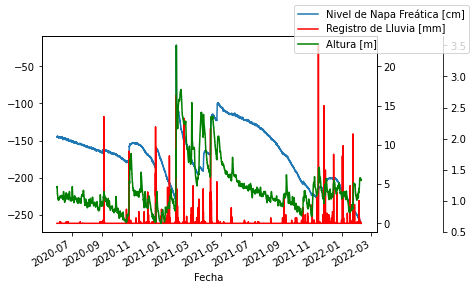

In [12]:
# datos de estaciones
ax = justiniano_posse_short.plot(x="Fecha", y="Nivel de Napa Freática [cm]", legend=False)
ax2 = ax.twinx()
justiniano_posse_short.plot(x="Fecha", y="Registro de Lluvia [mm]", ax=ax2, legend=False, color="r")
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
dique_aforador_short.plot(x="Fecha y Hora", y="Altura [m]", ax=ax3, legend=False, color="g")


ax.figure.legend()
plt.show()

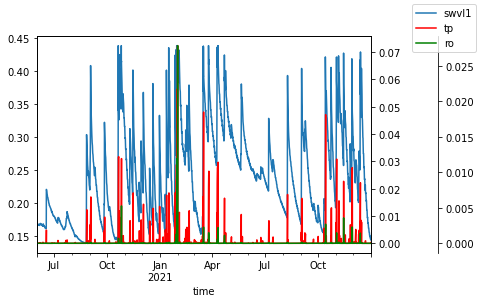

In [13]:
# datos de ERA5
era5land_loc = era5land.loc[{'latitude':-32.9, 'longitude': -62.6, 'time': slice('2020-06-01', '2021-12-31')}].to_dataframe().reset_index()
era5land_loc['time'] = pd.to_datetime(era5land_loc['time'], infer_datetime_format=True)

ax = era5land_loc.plot(x='time', y='swvl1', legend=False)
ax2 = ax.twinx()
era5land_loc.plot(x='time', y='tp', ax=ax2, legend=False, color="r")
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
era5land_loc.plot(x='time', y='ro', ax=ax3, legend=False, color="g")


ax.figure.legend()
plt.show()

<IPython.core.display.Javascript object>


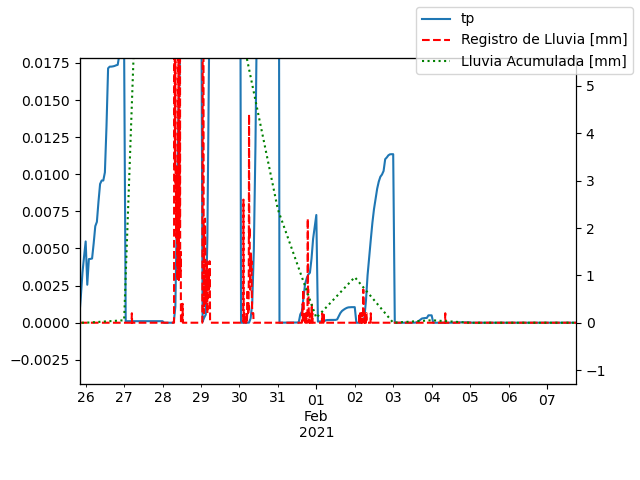

In [14]:
# Comparacion lluvia 
%matplotlib notebook

fig, ax = plt.subplots()
ax.plot(era5land_loc['time'], era5land_loc['tp'], label='tp')
ax2 = ax.twinx()
justiniano_posse_short.set_index('Fecha').plot(y="Registro de Lluvia [mm]", ax=ax2, legend=False, color="r", ls = 'dashed')
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
landsat_short.set_index('Fecha').plot(y="Lluvia Acumulada [mm]", ax=ax3, legend=False, color="g", ls='dotted')

ax.figure.legend()
plt.show()

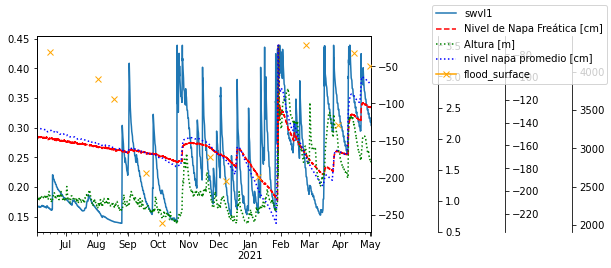

In [60]:
# Comparación de SM de ERA5, Altura de napa de JP, Altura de Río de Dique Aforador y superficie inundada de LandSat
fig, ax = plt.subplots()
ax.plot(era5land_loc['time'], era5land_loc['swvl1'], label='swvl1')
ax2 = ax.twinx()
justiniano_posse_short.set_index('Fecha').plot(y="Nivel de Napa Freática [cm]", ax=ax2, legend=False, color="r", ls = 'dashed')
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
dique_aforador_short.set_index('Fecha y Hora').plot(y="Altura [m]", ax=ax3, legend=False, color="g", ls='dotted')
ax4 = ax.twinx()
ax4.spines["right"].set_position(("axes", 1.4))
landsat_short.set_index('Fecha').plot(y="nivel napa promedio [cm]", ax=ax4, legend=False, color="b", ls='dotted')
ax5 = ax.twinx()
ax5.spines["right"].set_position(("axes", 1.6))
landsat_short.set_index('Fecha').plot(y="flood_surface", ax=ax5, legend=False, color="orange", marker='x')

ax.figure.legend()
plt.show()

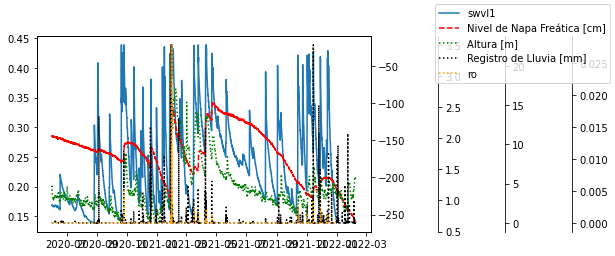

In [70]:
# Comparación de SM de ERA5, Altura de napa de JP, Altura de Río de Dique Aforador y runoff ERA5
fig, ax = plt.subplots()
ax.plot(era5land_loc['time'], era5land_loc['swvl1'], label='swvl1')
ax2 = ax.twinx()
justiniano_posse_short.set_index('Fecha').plot(y="Nivel de Napa Freática [cm]", ax=ax2, legend=False, color="r", ls = 'dashed')
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
dique_aforador_short.set_index('Fecha y Hora').plot(y="Altura [m]", ax=ax3, legend=False, color="g", ls='dotted')
ax5 = ax.twinx()
ax5.spines["right"].set_position(("axes", 1.4))
justiniano_posse_short.set_index('Fecha').plot(y="Registro de Lluvia [mm]", ax=ax5, legend=False, color="black", ls='dotted')
ax4 = ax.twinx()
ax4.spines["right"].set_position(("axes", 1.6))
ax4.plot(era5land_loc['time'], era5land_loc['ro'], label='ro', color='orange', ls='dotted')

ax.figure.legend()
plt.show()

<IPython.core.display.Javascript object>


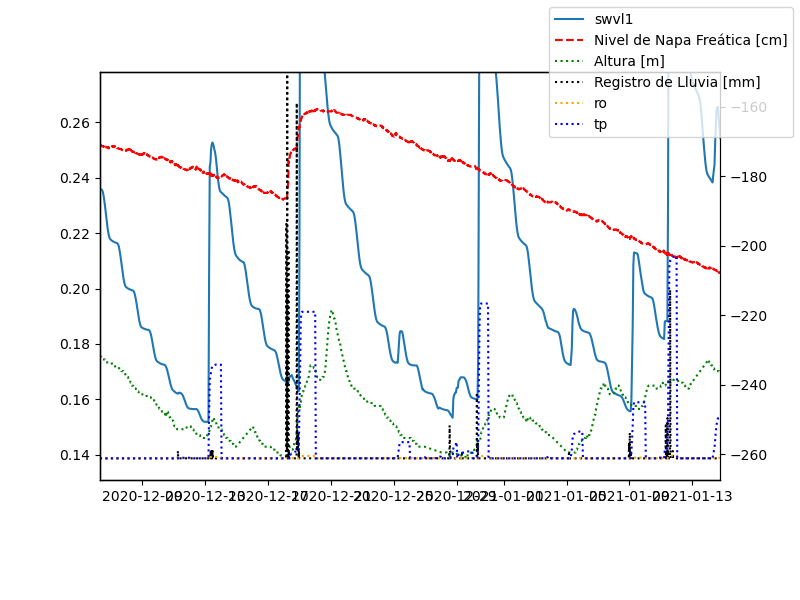

In [16]:
# Comparación de SM de ERA5, Altura de napa de JP, Altura de Río de Dique Aforador y runoff y tp ERA5
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(era5land_loc['time'], era5land_loc['swvl1'], label='swvl1')
ax2 = ax.twinx()
justiniano_posse_short.set_index('Fecha').plot(y="Nivel de Napa Freática [cm]", ax=ax2, legend=False, color="r", ls = 'dashed')
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
dique_aforador_short.set_index('Fecha y Hora').plot(y="Altura [m]", ax=ax3, legend=False, color="g", ls='dotted')
ax5 = ax.twinx()
ax5.spines["right"].set_position(("axes", 1.4))
justiniano_posse_short.set_index('Fecha').plot(y="Registro de Lluvia [mm]", ax=ax5, legend=False, color="black", ls='dotted')
ax4 = ax.twinx()
ax4.spines["right"].set_position(("axes", 1.6))
ax4.plot(era5land_loc['time'], era5land_loc['ro'], label='ro', color='orange', ls='dotted')
ax5 = ax.twinx()
ax5.spines["right"].set_position(("axes", 1.8))
ax5.plot(era5land_loc['time'], era5land_loc['tp'], label='tp', color='blue', ls='dotted')

ax.figure.legend()
plt.show()

#### En teoría los datos de LandSat son los mismos que los de Justiniano Posse, pero no estamos seguros, mejor usar los de JP.

<AxesSubplot:xlabel='Fecha'>

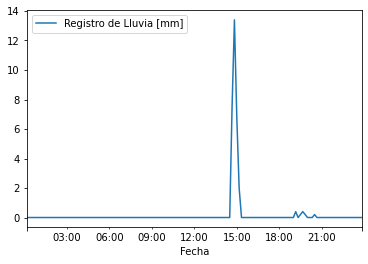

In [39]:
justiniano_posse_short.loc[justiniano_posse_short['Fecha']>'2021-02-13'].loc[justiniano_posse_short['Fecha']<'2021-02-14'].plot(x= 'Fecha', y='Registro de Lluvia [mm]')

<AxesSubplot:xlabel='Fecha'>

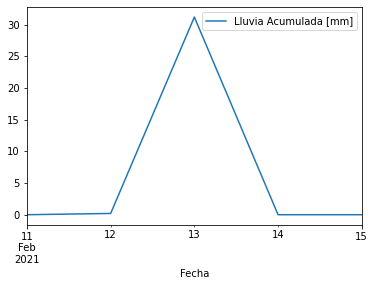

In [37]:
landsat_short.loc[landsat_short['Fecha']>'2021-02-10'].loc[landsat_short['Fecha']<'2021-02-16'].plot(x='Fecha',y='Lluvia Acumulada [mm]')

In [43]:
landsat_short

,Fecha,Lluvia Acumulada [mm],Rolling_5_Sum,nivel napa promedio [cm],flood_surface,mixwater_surface
0,2020-06-02,0.0,0.0,-144.5,NaN,NaN
1,2020-06-03,0.0,0.0,-145.3,NaN,NaN
2,2020-06-04,0.0,0.0,-145.5,NaN,NaN
3,2020-06-05,0.0,0.0,-145.3,NaN,NaN
4,2020-06-06,0.0,0.0,-145.3,NaN,NaN
...,...,...,...,...,...,...
330,2021-04-28,0.2,0.2,-104.0,NaN,NaN
331,2021-04-29,0.0,0.2,-104.7,NaN,NaN
332,2021-04-30,0.0,0.2,-104.8,NaN,NaN
333,2021-05-01,0.0,0.2,-105.3,4071.0,3616.0


<AxesSubplot:xlabel='time'>

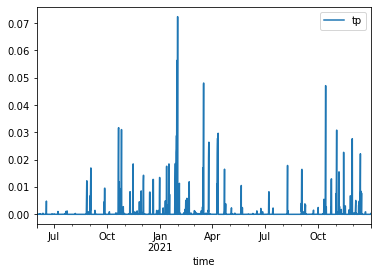

In [20]:
era5land_loc.plot(x="time", y="tp")

<AxesSubplot:xlabel='Fecha'>

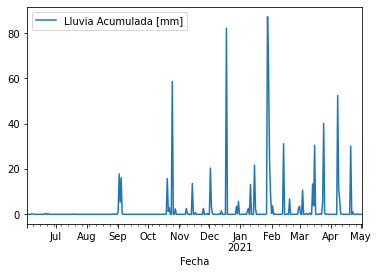

In [22]:
landsat_short.plot(x="Fecha", y="Lluvia Acumulada [mm]")

In [106]:
era5land_loc['time']

0       2020-06-01 00:00:00
1       2020-06-01 01:00:00
2       2020-06-01 02:00:00
3       2020-06-01 03:00:00
4       2020-06-01 04:00:00
                ...        
13891   2021-12-31 19:00:00
13892   2021-12-31 20:00:00
13893   2021-12-31 21:00:00
13894   2021-12-31 22:00:00
13895   2021-12-31 23:00:00
Name: time, Length: 13896, dtype: datetime64[ns]

In [107]:
justiniano_posse_short['Fecha']

0       2020-06-01 00:10:00
1       2020-06-01 00:20:00
2       2020-06-01 00:30:00
3       2020-06-01 00:40:00
4       2020-06-01 00:50:00
                ...        
88582   2022-02-08 10:30:00
88583   2022-02-08 10:40:00
88584   2022-02-08 10:50:00
88585   2022-02-08 11:00:00
88586   2022-02-08 11:10:00
Name: Fecha, Length: 88587, dtype: datetime64[ns]

In [108]:
landsat_short['Fecha']

0     2020-06-02
1     2020-06-03
2     2020-06-04
3     2020-06-05
4     2020-06-06
         ...    
330   2021-04-28
331   2021-04-29
332   2021-04-30
333   2021-05-01
334   2021-05-02
Name: Fecha, Length: 335, dtype: datetime64[ns]

In [115]:
############
# Observations
obs_path = '/datos/julian.giles/flash_flood/justiniano_posse/'

justiniano_posse = pd.read_csv(obs_path+'ClimaReporte_omixom_JustinianoPosse.csv', sep=';', low_memory=False, skip_blank_lines=True).dropna(how='all')

dique_aforador = pd.read_csv(obs_path+'Altura_diqueAforador_Estacion-4216.csv', sep=';', low_memory=False, skip_blank_lines=True, header=1).dropna(how='all')

landsat = pd.read_csv(obs_path+'data_Cappellettietal.csv', sep=',', low_memory=False, skip_blank_lines=True).dropna(how='all')

In [129]:
justiniano_posse['Fecha'] = pd.to_datetime(justiniano_posse['Fecha'], infer_datetime_format=True)
landsat['Fecha'] = pd.to_datetime(landsat['Fecha'], infer_datetime_format=True)

<AxesSubplot:xlabel='Fecha'>

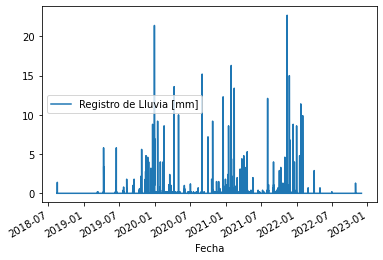

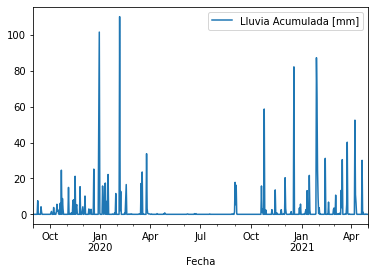

In [130]:
justiniano_posse.plot(x='Fecha', y ='Registro de Lluvia [mm]')
landsat.plot(x='Fecha', y='Lluvia Acumulada [mm]')

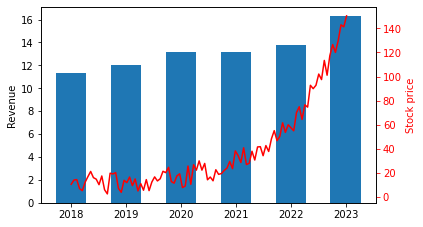

In [166]:
# Made up Stock price data
stock_price = np.random.random_sample(size=100)*20+np.exp(0.05*np.arange(100))
stock_price_df = pd.DataFrame({'dates':pd.date_range(start='1/1/2018', end='1/08/2023',periods=len(stock_price)), 'stock price':stock_price})
stock_price_df = stock_price_df.set_index('dates')

# Made up revenue data
revenue = np.random.random_sample(size=100)*20+np.exp(0.02*np.arange(100))
revenue_df= pd.DataFrame({'dates':pd.date_range(start='1/1/2018', end='1/08/2023',periods=len(revenue)), 'revenue': revenue})
revenue_df = revenue_df.set_index('dates')
revenue_df_agg = revenue_df.resample('Y').mean().reset_index()

# Plot two of them together
fig, ax = plt.subplots()
ax.bar(pd.to_datetime(revenue_df_agg['dates'].dt.year, format='%Y'), revenue_df_agg['revenue'], width=200)
ax.set_ylabel('Revenue')
ax1 = ax.twinx()
s = stock_price_df['stock price'].plot(ax = ax1, style = '-r')
ax1.set_ylabel('Stock price')
ax1.yaxis.label.set_color('r')
ax1.yaxis.label.set_color('r')
ax1.tick_params(axis='y', colors='r')
plt.savefig('collage-2.png')
plt.show()

In [132]:
stock_price_df

,stock price
dates,
2018-01-01 00:00:00.000000000,15.428797
2018-01-19 12:21:49.090909091,8.518496
2018-02-07 00:43:38.181818182,17.337158
2018-02-25 13:05:27.272727273,16.924797
2018-03-16 01:27:16.363636364,5.681720
...,...
2022-10-25 22:32:43.636363648,130.331592
2022-11-13 10:54:32.727272736,123.782451
2022-12-01 23:16:21.818181824,145.288293


In [152]:
revenue_df_agg

,dates,revenue
0,2018-12-31,11.085450
1,2019-12-31,10.581187
2,2020-12-31,13.298996
3,2021-12-31,12.316969
4,2022-12-31,17.773102
5,2023-12-31,15.047858


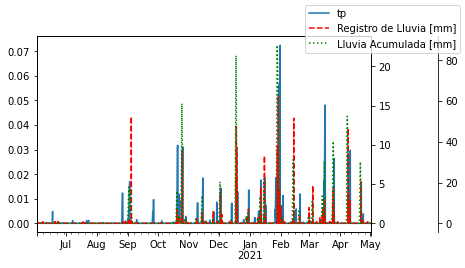

In [173]:
# Comparacion lluvia 
fig, ax = plt.subplots()
ax.plot(era5land_loc['time'], era5land_loc['tp'], label='tp')
ax2 = ax.twinx()
justiniano_posse_short.set_index('Fecha').plot(y="Registro de Lluvia [mm]", ax=ax2, legend=False, color="r", ls = 'dashed')
ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
landsat_short.set_index('Fecha').plot(y="Lluvia Acumulada [mm]", ax=ax3, legend=False, color="g", ls='dotted')

ax.figure.legend()
plt.show()

In [174]:
landsat_short

,Fecha,Lluvia Acumulada [mm],Rolling_5_Sum,nivel napa promedio [cm],flood_surface,mixwater_surface
0,2020-06-02,0.0,0.0,-144.5,NaN,NaN
1,2020-06-03,0.0,0.0,-145.3,NaN,NaN
2,2020-06-04,0.0,0.0,-145.5,NaN,NaN
3,2020-06-05,0.0,0.0,-145.3,NaN,NaN
4,2020-06-06,0.0,0.0,-145.3,NaN,NaN
...,...,...,...,...,...,...
330,2021-04-28,0.2,0.2,-104.0,NaN,NaN
331,2021-04-29,0.0,0.2,-104.7,NaN,NaN
332,2021-04-30,0.0,0.2,-104.8,NaN,NaN
333,2021-05-01,0.0,0.2,-105.3,4071.0,3616.0


In [162]:
justiniano_posse_short['Fecha']

0       2020-06-01 00:10:00
1       2020-06-01 00:20:00
2       2020-06-01 00:30:00
3       2020-06-01 00:40:00
4       2020-06-01 00:50:00
                ...        
88582   2022-02-08 10:30:00
88583   2022-02-08 10:40:00
88584   2022-02-08 10:50:00
88585   2022-02-08 11:00:00
88586   2022-02-08 11:10:00
Name: Fecha, Length: 88587, dtype: datetime64[ns]

In [ ]:
dique_aforador_xr = xr.Dataset.from_dataframe(dique_aforador)

In [49]:
dique_aforador_xr

<xarray.Dataset>
Dimensions:       (index: 14783)
Coordinates:
  * index         (index) int64 0 1 2 3 4 5 ... 14778 14779 14780 14781 14782
Data variables:
    Fecha y Hora  (index) object '19/12/2019 13:00' ... '08/02/2022 19:00'
    Altura [m]    (index) float64 0.0 0.0 0.0 0.0 0.0 ... 1.34 1.33 1.33 1.33